In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import math

from matplotlib import animation, rc
from IPython.display import HTML


args = {  
'exciton_energy': 1.5,
'number_of_monomers' : 4,
'displacement_between_monomers' : np.array([1, 0, 0]), 
'transition_dipole_moment' : np.array([0, 0, 0.5]) 
}  

sf = wptherml.SpectrumFactory()  
test = sf.spectrum_factory('Frenkel', args)

print(test._compute_H0_element(1, 0) )
print("coords")
print(test.coords)
print("transition dipole moment")
print(test.transition_dipole_moment)


Exciton Energy is   1.5
0.0
coords
[[0. 1. 2. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
transition dipole moment
[0.  0.  0.5]


In [2]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for plot
ax.set_xlim((-1, 3))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
plt.show()

In [3]:
test.compute_exciton_wavefunction_site_basis()
#g_2 = test.compute_exciton_wavefunction_site_basis(2)
#plt.plot(test.x, )
#plt.plot(test.x, g_2)
#plt.show()


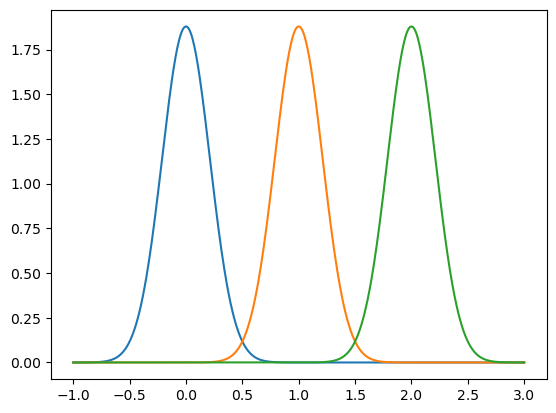

In [5]:
plt.plot(test.x, test.phi[:,0])
plt.plot(test.x, test.phi[:,1])
plt.plot(test.x, test.phi[:,2])
plt.show()

In [ ]:
N_time = 50
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    E = test.exciton_energy
    y = np.sqrt(0.5) * np.cos(E * t) * g_1 + np.sqrt(0.5) * np.sin(E * t) * g_2
    line.set_data(test.x, y)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=200, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim